<center><h1>Seattle Traffic Incidents:</h1></center>
<center><h3> The Insurers' Perspective.  </h3> </center>

Let's import the necessary files for data analysis

In [1]:
#import pandas and numpy
import pandas as pd # this is important in any analysis
import numpy as np #for any data science analysis

<h3> Data Procurement </h3>

In [2]:
#import the csv file from the Seattle incident's website
#!wget -O Collisions.csv https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv

In [3]:
#create a dataframe for the csv.
df = pd.read_csv('Collisions.csv')
print("The shape of this dataframe is:", df.shape)

The shape of this dataframe is: (221738, 40)


This is the main dataframe from where the data is imported to other dataframes. The analysis is done on
<ul>
    <li>Incidents involving Driver's Fault</li>
    <li>The time incident happened</li>
    <li>Incident's from the city center</li>
    <li>Parked Vehicle involved</li>
</ul>
This df dataframe has 40 columns, we only need some of these columns for analysis. Hence we rewrite the dataframe and extract only the once we need. These columns will be used in further analysis.

In [4]:
df_parked = df.loc[df["HITPARKEDCAR"]=='Y']

<h3> Data Conditioning </h3>

In [5]:
# selecting important columns from DataFrame.
df = df[['X','Y','SPEEDING','INATTENTIONIND','UNDERINFL','VEHCOUNT','INJURIES','SERIOUSINJURIES','FATALITIES','INCDTTM','WEATHER','LIGHTCOND','ROADCOND','HITPARKEDCAR','ADDRTYPE']]

In [6]:
df.shape

(221738, 15)

now the shape is 14. We need to fillout the empty rows, and conditioning the data


In [7]:
df["INATTENTIONIND"].value_counts()

Y    30188
Name: INATTENTIONIND, dtype: int64

In [8]:
df['SPEEDING'].fillna('N', inplace=True) # the dataframe has Y for speeding but nothing if not speeding.
df['INATTENTIONIND'].fillna('N',inplace=True)# the dataframe has Y for inattention but nothing if not speeding.
df = df.replace({'UNDERINFL':{'1':'Y','0':'N'}})
df = df.replace({'INATTENTIONIND':{'1':'Y','0':'N'}})
df['SPEEDING'].fillna(False, inplace=True)
df['INATTENTIONIND'].fillna(False,inplace=True)
df = df.replace({'UNDERINFL':{'N': False ,'Y': True ,'1': True ,'0': False }})
df = df.replace({'INATTENTIONIND':{'Y':True,'N':False}})
df = df.replace({'SPEEDING':{'Y':True, 'N':False}})
shape_before = df.shape
print ("shape before removing NaN:", shape_before)
df.dropna(axis=0,inplace=True)
shape_after = df.shape
print ("shape after removing NaN:", shape_after)

shape before removing NaN: (221738, 15)
shape after removing NaN: (189582, 15)


the dataframe is now reduced to 189582 rows from 221738 rows, this means that we had some losses due to dropping NAN values in the dataframe.
Next step is to derive the distance from the city center and hour of the accident happened. 

In [9]:
# deriving the data from the X and Y (Longitudes and Latitudes from the df dataframe)
import math
dist = [] # create an empty list in python
for lat, lng, in zip(df.Y, df.X):
    R = 6371e3; # metres
    seaLat = 47.6060
    seaLng = -122.3321
    theta1= lat * 3.1416/180; # φ, λ in radians
    theta2 = seaLat  * 3.1416/180;
    deltatheta = (seaLat-lat) * 3.1416/180;
    deltalamda = (seaLng-lng) * 3.1416/180;
    a = math.sin(deltatheta/2) * math.sin(deltatheta/2) + math.cos(theta1) * math.cos(theta2) * math.sin(deltalamda/2) * math.sin(deltalamda/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c  /1000; # in metres
    d = round (d,1)
    dist.append(d)

df["DIST"] = dist
max(dist)

14.6

In [10]:
# deriving the hour of incident from the INCDTTM
import datetime
import math
daytime=[]
dayhour=[]
dayslot = []
for d in df.INCDTTM:
    try:
        timestr = d.split()[1]
        AMPM=d.split()[2]
        if AMPM == "PM":
            if timestr.split(":")[0] == "12":
                hour = int(timestr.split(":")[0])
            else:
                hour = (int(timestr.split(":")[0]) + 12)
        else:
            hour = timestr.split(":")[0]
                
    except:
        timestr = ""
        hour = "-1"
    daytime.append(timestr)
    dayhour.append(hour)
    dayslot.append(AMPM)

df['DAYTIME'] = daytime
df['HOUR']= dayhour

In [11]:
df.shape

(189582, 18)

There are now 17 columns in the dataframe, 3 columns that were added are DIST for distance, HOUR for the time of the day and DAYIME for time complete time of the day

<h3> Methodology </h3>

<h4>1. Driver's Fault Analysis </h4>

In [12]:
df_drvFlt = df.groupby(["UNDERINFL","SPEEDING","INATTENTIONIND","VEHCOUNT","INJURIES","SERIOUSINJURIES","FATALITIES"]).size().reset_index(name = "Freq")

In [13]:
# create a new column if the drivers has any of speeding, inattention or under-influence as true
Flt = df_drvFlt.UNDERINFL | df_drvFlt.SPEEDING | df_drvFlt.INATTENTIONIND
df_drvFlt["FAULT"] = Flt

In [14]:
df_drvFlt.sort_values(by=['Freq'])

,UNDERINFL,SPEEDING,INATTENTIONIND,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,Freq,FAULT
601,True,True,True,6,0,0,0,1,True
184,False,False,True,2,9,0,0,1,True
443,True,False,False,4,5,0,1,1,True
442,True,False,False,4,5,0,0,1,True
441,True,False,False,4,4,1,0,1,True
...,...,...,...,...,...,...,...,...,...
7,False,False,False,1,0,0,0,6581,False
11,False,False,False,1,1,0,0,9652,False
167,False,False,True,2,0,0,0,14966,True
36,False,False,False,2,1,0,0,19188,False


<Figure size 432x288 with 0 Axes>

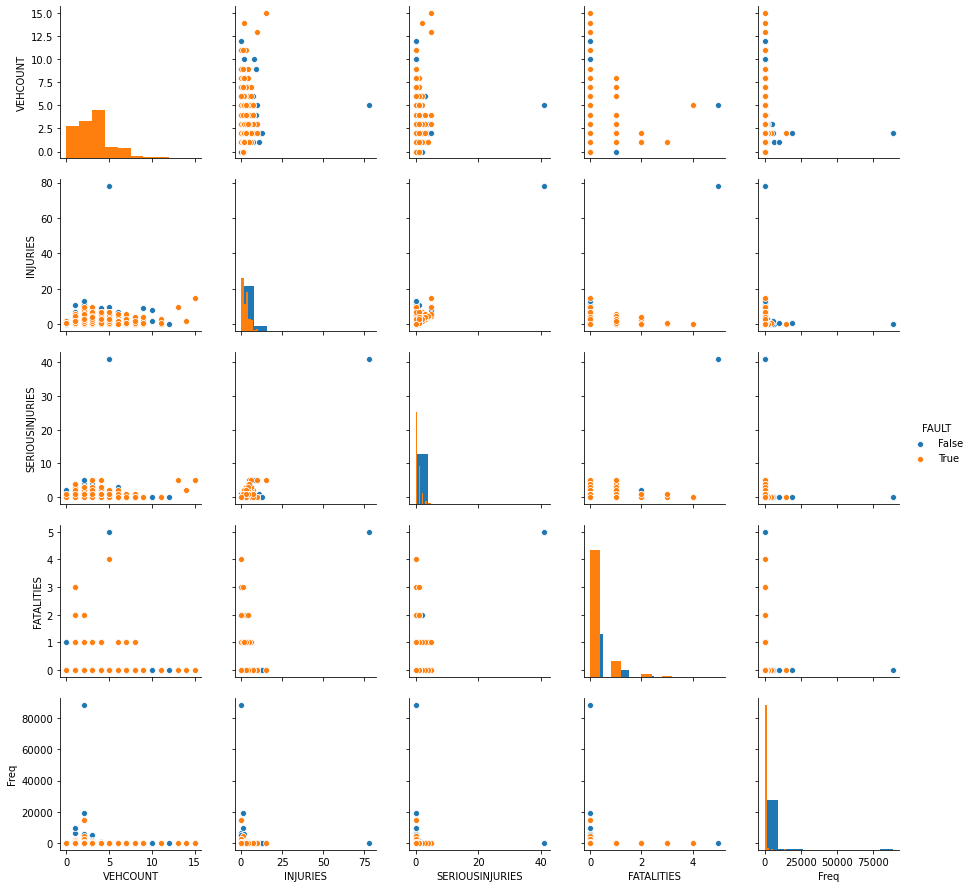

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
df_pair = df_drvFlt[["VEHCOUNT","INJURIES","SERIOUSINJURIES","FATALITIES","FAULT","Freq"]] #,"INJURIES",
import seaborn as sns
plt.figure()
sns.pairplot(df_pair,hue='FAULT',diag_kind='hist',vars=["VEHCOUNT","INJURIES","SERIOUSINJURIES","FATALITIES","Freq"])
plt.show()

The SNS plot shows that higher numbers with VEHCOUNT, FREQ, FATALITIES, SERRIOUSINJURIES and INJURIES are crowded by incidents with drivers fault. This means that drivers under influence, speeding or inattention have a higher risk of making more damage. Although an analysis can be done on driver's fault, there is no point to it. The idea of getting data from an incident (like fatalities, injuries and vehicle count) and then determining whether the driver was at fault or not is of no use. This analysis is more intended for general readers to understand the consequences of speeding, inattention or distracted driving.

<h4> 2. Time of Accident </h4>

In [16]:
# change the format of the HOUR column
df.dtypes

X                  float64
Y                  float64
SPEEDING              bool
INATTENTIONIND        bool
UNDERINFL           object
VEHCOUNT             int64
INJURIES             int64
SERIOUSINJURIES      int64
FATALITIES           int64
INCDTTM             object
WEATHER             object
LIGHTCOND           object
ROADCOND            object
HITPARKEDCAR        object
ADDRTYPE            object
DIST               float64
DAYTIME             object
HOUR                object
dtype: object

In [17]:
df['HOUR'] = df['HOUR'].astype(int)

Let's plot the hours and number of accidents happening at that time of the day. Where Xt is the time of accidents and Yt are the number of accidents happening during that time of the day. Here, the time 5 means that accidents happening from 5 am to 6 am.

Text(0, 0.5, 'number of accidents')

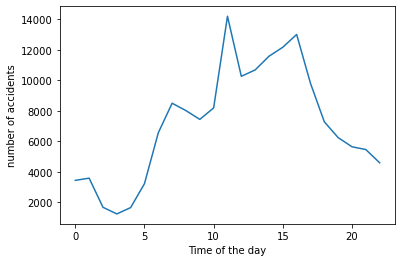

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
Yt = df['HOUR'].value_counts().sort_index() # to get the data sorted by Distance from center of city
Xt = np.arange(0,23,1) #-1 signifies no data hence eleminating that
plt.plot(Xt,Yt[1:24])
plt.xlabel("Time of the day")
plt.ylabel("number of accidents")

There is a clear trend in the data, a polynomial analysis is can be done to determine the trend and find the peak hours of accidents.

In [19]:
#import necessary libraries
import pylab as pl
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import train_test_split # to split X,Y
Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt,Yt[1:25], test_size=0.33, random_state=42)
Xt_train.shape

(15,)

In [20]:
Xt_train=Xt_train[:,None]
yt_train=yt_train[:,None]
Xt_test=Xt_test[:,None]
yt_test=yt_test[:,None]
Xt_train.shape

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


(15, 1)

In [21]:
# fit in polynomial regression
poly = PolynomialFeatures(degree=4)
train_xt_poly = poly.fit_transform(Xt_train)
train_xt_poly

array([[1.00000e+00, 5.00000e+00, 2.50000e+01, 1.25000e+02, 6.25000e+02],
       [1.00000e+00, 2.00000e+00, 4.00000e+00, 8.00000e+00, 1.60000e+01],
       [1.00000e+00, 1.10000e+01, 1.21000e+02, 1.33100e+03, 1.46410e+04],
       [1.00000e+00, 2.00000e+01, 4.00000e+02, 8.00000e+03, 1.60000e+05],
       [1.00000e+00, 3.00000e+00, 9.00000e+00, 2.70000e+01, 8.10000e+01],
       [1.00000e+00, 4.00000e+00, 1.60000e+01, 6.40000e+01, 2.56000e+02],
       [1.00000e+00, 1.80000e+01, 3.24000e+02, 5.83200e+03, 1.04976e+05],
       [1.00000e+00, 1.60000e+01, 2.56000e+02, 4.09600e+03, 6.55360e+04],
       [1.00000e+00, 2.10000e+01, 4.41000e+02, 9.26100e+03, 1.94481e+05],
       [1.00000e+00, 2.20000e+01, 4.84000e+02, 1.06480e+04, 2.34256e+05],
       [1.00000e+00, 7.00000e+00, 4.90000e+01, 3.43000e+02, 2.40100e+03],
       [1.00000e+00, 1.00000e+01, 1.00000e+02, 1.00000e+03, 1.00000e+04],
       [1.00000e+00, 1.40000e+01, 1.96000e+02, 2.74400e+03, 3.84160e+04],
       [1.00000e+00, 1.90000e+01, 3.61

In [22]:
# find the intercepts and coeff of the poly fit
from sklearn import linear_model
clf = linear_model.LinearRegression()
train_yt_ = clf.fit(train_xt_poly, yt_train)
# The coefficients
print ('Coefficients: ', clf.coef_)
print ('Intercept: ',clf.intercept_)

Coefficients:  [[ 0.00000000e+00 -2.57480254e+03  7.44598045e+02 -5.16710881e+01
   1.05559032e+00]]
Intercept:  [3843.84221743]


Text(0, 0.5, 'Frequency of accidents')

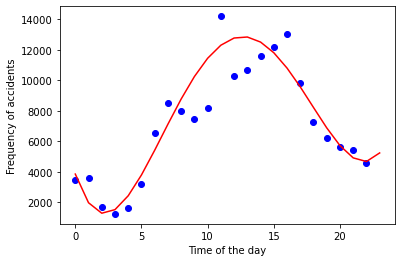

In [23]:
plt.scatter(Xt,Yt[1:25],  color='blue')
XX =  np.arange(0,24,1)
yy = clf.intercept_[0]+ clf.coef_[0][1]*XX+ clf.coef_[0][2]*np.power(XX, 2)+clf.coef_[0][3]*np.power(XX,3) +clf.coef_[0][4]*np.power(XX,4)#+clf.coef_[0][5]*np.power(XX,5)#+clf.coef_[0][6]*np.power(XX,6)
plt.plot(XX, yy, '-r' )
plt.xlabel("Time of the day")
plt.ylabel("Frequency of accidents")

A clear trend is now visible with the polynominal regression, let's find the accuracy of this regression

In [24]:
from sklearn.metrics import r2_score

test_xt_poly = poly.fit_transform(Xt_test)
test_yt_ = clf.predict(test_xt_poly)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_yt_ - yt_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_yt_ -yt_test) ** 2))
print("R2-score: %.2f" % r2_score(test_yt_ , yt_test) )

Mean absolute error: 1357.47
Residual sum of squares (MSE): 2799791.23
R2-score: 0.80


The results show R2-score as 0.8 which can be considered as good. Let's go further into this analysis and find if we can do anything about distance and time.

In [25]:
# group the time and distance
df_Time = df.groupby(["HOUR","DIST"]).size().reset_index(name = "Freq")

In [26]:
# -1 in time represent that time was not given when the incident was reported, let;s remove this value
df_Time = df_Time[df_Time.HOUR != -1]

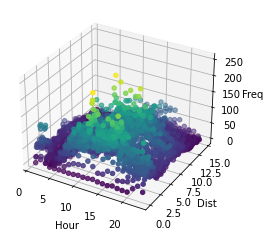

In [27]:
from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure().gca(projection='3d')
threedee.scatter(df_Time['HOUR'], df_Time['DIST'], df_Time['Freq'], c = df_Time['Freq'])
threedee.set_xlabel('Hour')
threedee.set_ylabel('Dist')
threedee.set_zlabel('Freq')
plt.show()

From the 3D plot above there is a clear correaltion between time and distance of the accident with Frequency (number of accidents). When a decision tress, KNN analysis was done on this we were not able to get any accurate result (best accuracy of 0.056). A regression can be performed on this, however, this would require us to perform a Multiple Polynomial Regression. This is beyond the scope of this project. 
Here we come to the next analysis, which is analysis of distance and accidents from the city center.

<h3> 3. Distance from City Center </h3>

Text(0, 0.5, 'Frequency of accidents')

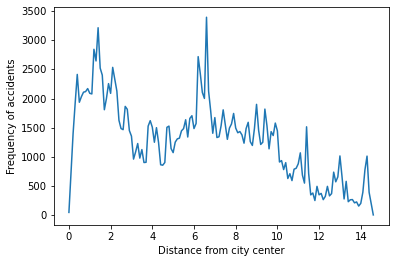

In [28]:
# let plot the distance vs. incidents data
import matplotlib as mpl
import matplotlib.pyplot as plt
Yd = df['DIST'].value_counts().sort_index() # to get the data sorted by Distance from center of city
Xd = np.arange(0.0,14.7,0.1)
plt.plot(Xd,Yd)

plt.xlabel("Distance from city center")
plt.ylabel("Frequency of accidents")

In [29]:
from sklearn.model_selection import train_test_split # to split X,Y
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd,Yd, test_size=0.33, random_state=42)
Xd_train.shape

(98,)

In [30]:
Xd_train=Xd_train[:,None]
yd_train=yd_train[:,None]
Xd_test=Xd_test[:,None]
yd_test=yd_test[:,None]
Xd_train.shape

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


(98, 1)

In [31]:
poly = PolynomialFeatures(degree=6)
train_xd_poly = poly.fit_transform(Xd_train)
#train_x_poly

Similar to the time analysis we do the distance analysis and find the coeff and intercept

In [32]:
clf = linear_model.LinearRegression()
train_yd_ = clf.fit(train_xd_poly, yd_train)
# The coefficients
print ('Coefficients: ', clf.coef_)
print ('Intercept: ',clf.intercept_)

Coefficients:  [[ 0.00000000e+00  3.12943965e+03 -2.06535922e+03  5.27853158e+02
  -6.31163299e+01  3.54482532e+00 -7.56485051e-02]]
Intercept:  [832.56522105]


Text(0, 0.5, 'Frequency of accidents')

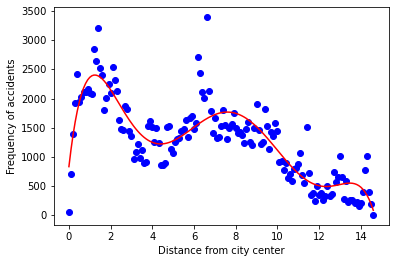

In [33]:
plt.scatter(Xd,Yd,  color='blue')
XX = np.arange(0.0, 14.7, 0.1)
yy = clf.intercept_[0]+ clf.coef_[0][1]*XX+ clf.coef_[0][2]*np.power(XX, 2)+clf.coef_[0][3]*np.power(XX, 3)+clf.coef_[0][4]*np.power(XX, 4)+clf.coef_[0][5]*np.power(XX, 5)+clf.coef_[0][6]*np.power(XX, 6)
plt.plot(XX, yy, '-r' )
plt.xlabel("Distance from city center")
plt.ylabel("Frequency of accidents")

lets find the R2 score of this test

In [34]:
from sklearn.metrics import r2_score

test_xd_poly = poly.fit_transform(Xd_test)
test_yd_ = clf.predict(test_xd_poly)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_yd_ - yd_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_yd_ -yd_test) ** 2))
print("R2-score: %.2f" % r2_score(test_yd_ , yd_test) )

Mean absolute error: 290.25
Residual sum of squares (MSE): 159350.72
R2-score: 0.63


The accuracy score was 0.63 which still can be used. A better understanding of this can be done by plotting the incident hotspot on the map of Seattle

In [35]:
# lets use groupby to find the frequency of accidents happening in the areas
df['Y'] = df['Y'].round(2) # this is done to reduce the size of 'Y' and 'X' as it will give better understanding of zones. 
df['X'] = df['X'].round(2) # 
df_spot = df.groupby(["X","Y"]).size().reset_index(name = "Freq")
df_spot.shape

(305, 3)

In [36]:
df_spot.sort_values(by="Freq")

,X,Y,Freq
3,-122.42,47.66,1
4,-122.42,47.67,1
63,-122.37,47.50,2
10,-122.41,47.66,2
246,-122.29,47.64,3
...,...,...,...
156,-122.33,47.62,3887
177,-122.32,47.61,4193
154,-122.33,47.60,5175
155,-122.33,47.61,5450


spots with longitude that is X

Text(0, 0.5, 'Frequecy of accidents')

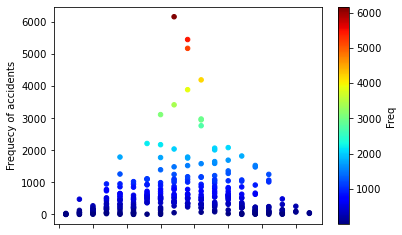

In [37]:
df_spot.plot.scatter('X','Freq',c = 'Freq',colormap='jet')
plt.xlabel("Longitutdes")
plt.ylabel("Frequecy of accidents")

also for Latitude, Y

Text(0, 0.5, 'Frequecy of accidents')

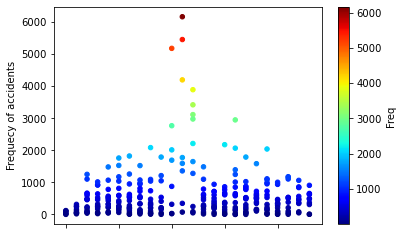

In [38]:
df_spot.plot.scatter('Y','Freq',c = 'Freq',colormap='jet')
plt.xlabel("Latitidudes")
plt.ylabel("Frequecy of accidents")

From this it looks like we have a lot of values with 200 incidents, hence lets create another database with very high incident rate. These are the spot where insurance companies have to be careful while giving quote

In [39]:
df_hotSpot = df_spot
df_hotSpot.head(5)

,X,Y,Freq
0,-122.42,47.57,16
1,-122.42,47.58,32
2,-122.42,47.65,6
3,-122.42,47.66,1
4,-122.42,47.67,1


In [40]:
#Import Folium Library for Mapping
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print('Folium installed and imported!')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.5
  latest version: 4.9.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36he6145b8_1001         347 KB  conda-forge
    certifi-2020.6.20          |   py36h9880bd3_2         151 KB  conda-forge
    chardet-3.0.4              |py36h9880bd3_1008         194 KB  conda-forge
    cryptography-3.1.1         |   py36h5d711a5

In [41]:
df_hotSpot['marker_color'] = pd.cut(df_hotSpot['Freq'], bins=4, labels=[ 'green', 'blue','yellow', 'red'])
df_hotSpot.shape

(305, 4)

In [42]:
df_hotSpot['Freq']

0       16
1       32
2        6
3        1
4        1
      ... 
300     97
301    255
302     76
303     33
304     52
Name: Freq, Length: 305, dtype: int64

Text(0, 0.5, 'Frequency of Incidents')

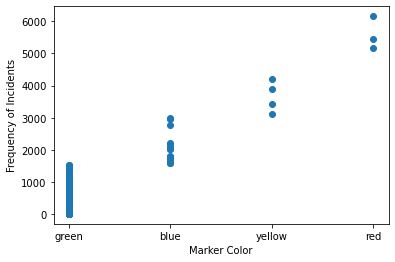

In [43]:
plt.scatter(df_hotSpot['marker_color'],df_hotSpot['Freq'])
plt.xlabel("Marker Color")
plt.ylabel("Frequency of Incidents")

This means that from green is frequency between 1 to 1500, blue is 1500 to 3000, yellow is 3000 to 4500 and red is 4500 to 6000

In [44]:
df_hotSpot.shape

(305, 4)

In [45]:
seattle_map = folium.Map(location=[47.6062, -122.3321], zoom_start=11)
# Seattle Location 47°36′35″N 122°19′59″W

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, clr in zip(df_hotSpot.Y, df_hotSpot.X, df_hotSpot.marker_color):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color= clr,
            fill=True,
            fill_color= clr,
            fill_opacity=0.3
        )
    )

# add incidents to map
seattle_map.add_child(incidents)

The incients are high near the regions like Pioneer square, Westlake and First Hill have very high frequency of accidents, followed by areas like University Street, Seattle Center, Yesler Terrace. Mostly the heart of the city is where the frequency of the accidents is high. From insurance perspective this is the very high risk zone

<h3> 4. Analysis of Parked Cars in Incident </h3>

In [46]:
# create a new dataframe from the original dataframe df
df_LigWeaRd = df.groupby(["WEATHER","LIGHTCOND","ROADCOND","HITPARKEDCAR"]).size().reset_index(name = "Freq")

In [47]:
# for Decision Tree Analysis repalce the values to integer
df_LigWeaRd = df_LigWeaRd.replace({'ROADCOND':{'Dry':0,'Sand/Mud/Dirt':1,'Wet':2,'Standing Water':3,'Oil':4,'Snow/Slush':5, 'Ice':6,'Other':7,'Unknown':8}})
df_LigWeaRd = df_LigWeaRd.replace({'LIGHTCOND':{'Daylight':0,'Dawn':1,'Dusk':2,'Dark - Street Lights On':3,'Dark - Street Lights Off':4,'Dark - No Street Lights':5,'Dark - Unknown Lighting':6,'Other':7,'Unknown':8,}})
df_LigWeaRd = df_LigWeaRd.replace({'WEATHER':{'Clear':0,'Partly Cloudy':1,'Overcast':2,'Severe Crosswind':3,'Blowing Sand/Dirt':4,'Fog/Smog/Smoke':5,'Raining':6,'Snowing':7,'Sleet/Hail/Freezing Rain':8,'Other':9,'Unknown':10}})


In [48]:
Xh = df_LigWeaRd[['ROADCOND','LIGHTCOND','WEATHER']].values # Removing the driver's parameters ,'ADDRTYPE'
yh = df_LigWeaRd["HITPARKEDCAR"]
Xh[0:5]

array([[0, 5, 4],
       [0, 3, 4],
       [0, 3, 4],
       [6, 3, 4],
       [5, 3, 4]])

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
Xh_train, Xh_test, yh_train, yh_test = train_test_split(Xh, yh, test_size = 0.2, random_state = 0)

In [50]:
print('the shape of Xh_train is',Xh_train.shape)
print('and yh_train is', yh_train.shape)
print('Xh_test',Xh_test.shape)
print('yh_test',yh_test.shape)

the shape of Xh_train is (384, 3)
and yh_train is (384,)
Xh_test (96, 3)
yh_test (96,)


In [51]:
collisionTree = DecisionTreeClassifier(criterion="entropy", max_depth =4)
collisionTree # it shows the default parameters
collisionTree.fit(Xh_train,yh_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [52]:
predTree = collisionTree.predict(Xh_test)

In [53]:
from sklearn import metrics
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(yh_test, predTree))

DecisionTrees's Accuracy:  0.6979166666666666


This gives an accuracy of 69%, this can be considered as a good result

In [54]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

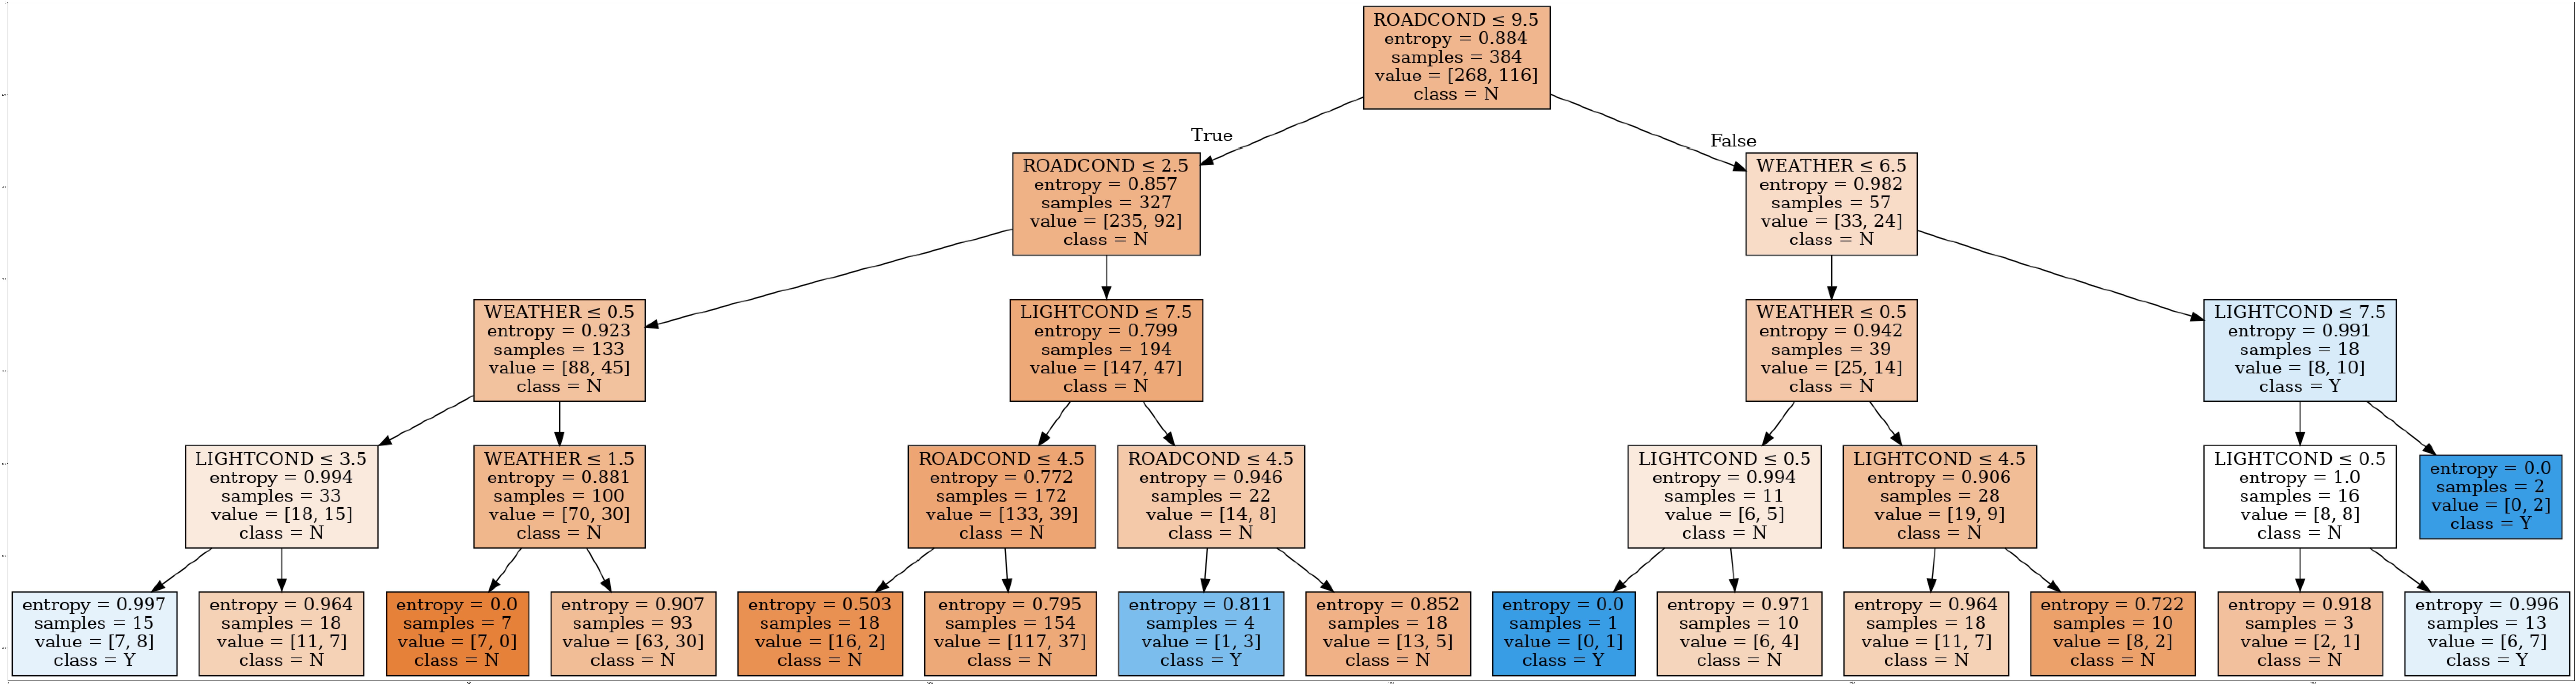

In [55]:
dot_data = StringIO()
filename = "collisiontree.png"
featureNames = df_LigWeaRd.columns[0:3]
targetNames = df_LigWeaRd["HITPARKEDCAR"].unique().tolist()
out=tree.export_graphviz(collisionTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(yh_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(200,400))
plt.imshow(img,interpolation='nearest')

Various conclusions can be derived from this decision tree. 
The parked vehicle are hit when 
<ul>
    <li>Good Road Conditions, Weather and Light Condition. (Entropy = 0.997, pure node) </li>
    <li>Road Conditions are Oily or snow/slush with fairly good lighting conditions. (Entropy = 0.811, pure node)</li>
    <li>Road Conditions are unknown,Weather is snow, sleet or unknown, light condition is known and it is not daylight. (Entropy = 0.996, pure node)</li>
    <li>and in other 2 cases, but since the entropy is 0.0, not worth to be investigating</ul>

In [56]:
df["ADDRTYPE"].value_counts()

Block           123967
Intersection     65615
Name: ADDRTYPE, dtype: int64

It is important to see that 167 parked cars were hit near intersection. Now, in US, usually we have no-parking zone close to any intersection. These cars were therefore (possibily) parked in that no parking zone. Also, from all the parked cars only 2 cars were in an incident out of a total 11,782 hit parked cars, that is less than 0.2%.

A person who parks in alley can get a better quote than one parking on the block.

With all the above considerations, we can now come to a conclusion that we have considerable information which can make drivers safe and insurance companies to work on better rates and give good returns on claims made by it's customers. The insurers and insured can work hand in hand for better insurance experience incase they are involved in an incident.
 At this point, I would like to ask the readers of this report to understand the importance of safe driving and the consequences of under-influence, distracted driving and speeding on the whole society.
    <h3><center>"Don't Drink and Drive"</center></h3>
<h4> This marks the end of report.</h4>

Appendix A: A Special Case

In [62]:
# let's find the maximum number of injuries, serious injuries and fatalties in seattle
print("The max injuries in an accidents was:" ,df["INJURIES"].max())
print("The max serious injuries in an accidents was:" ,df["SERIOUSINJURIES"].max())
print("The max fatalities in an accident were:" ,df["FATALITIES"].max())

The max injuries in an accidents was: 78
The max serious injuries in an accidents was: 41
The max fatalities in an accident were: 5


In [65]:
injuries = df.loc[df['INJURIES'] == 78]
injuries

,X,Y,SPEEDING,INATTENTIONIND,UNDERINFL,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDTTM,WEATHER,LIGHTCOND,ROADCOND,HITPARKEDCAR,ADDRTYPE,DIST,DAYTIME,HOUR
160908,-122.35,47.65,False,False,False,5,78,41,5,9/24/2015 11:11:00 AM,Clear,Daylight,Dry,N,Block,4.7,11:11:00,11


The above row shows that all the maximum injuries, Serious injuries and Fataliees happened in one incident. The driver was not impaired, not speeding or not distracted. it was 11:11 am on Sept 24,2015. A quick search on google with this date will show us something. 

This is the Aurora Bridge Accident that happened between an amphibious tour vehicle and a bus. On the Seattle's 1310 news <a href= "https://www.1310news.com/2015/09/24/the-latest-2-killed-9-critically-injured-as-amphibious-tour-vehicle-charter-bus-crash/"> website </a>, we can find more details.